In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reinforcement Learning and Dynamic Optimization - Assignment 1

## Introduction
In this assignment we tackle a news recommendation problem using a stochastic multi-armed bandit framework. The goal is to maximize user clicks by selecting two news articles (one for the top of the page and one for the bottom) from a set of 5 articles. The user clicks the top article with probability *p₁* and, if not clicked, then clicks the bottom article with probability *p₂*. This results in an overall click probability for a pair (i, j) of:

<p align="center">
  P(click) = p<sub>i</sub> + (1 - p<sub>i</sub>) × p<sub>j</sub>
</p>




## Problem Setup
- **Articles and Pairs:**  
  - We have **K = 5** articles.
  - The problem is converted into a standard bandit problem by treating each distinct ordered pair (i, j) with i ≠ j as an arm (total of 20 arms).
- **True CTR Values:**  
  - Each article’s click-through rate (CTR) is drawn uniformly from [0.0, 0.7] using a fixed seed ([10] last two digits of student ID).
- **User Behavior Model:**  
  - The user clicks the top article with its CTR probability.
  - If the top article is not clicked, the user then considers the bottom article.


In [ ]:
np.random.seed(10) # Last two digits of student ID (10)

# Number of news articles and pairs
K = 5  # total articles
pairs = [(i, j) for i in range(K) for j in range(K) if i != j]  #all possible (i, j) pairs
num_pairs = len(pairs)

# Horizons (small/big)
T_values = [1000, 10000]

# True CTR probabilities for every article
ctr_true = np.random.uniform(0.0, 0.7, K)  # unifomly sampled in [0.0, 0.7]

# Expected CTR probability for each pair P(i, j) = p_i + (1 - p_i) * p_j
p_clicks = {pair: ctr_true[pair[0]] + (1 - ctr_true[pair[0]]) * ctr_true[pair[1]] for pair in pairs}

best_pair = max(p_clicks, key=p_clicks.get)  # best pair with highest expected click probability
best_p_click = p_clicks[best_pair]

print("True click probabilities for each article:", np.round(ctr_true, 2))
print("Best article pair:", best_pair, "with expected click probability:", round(best_p_click, 2))


True click probabilities for each article: [0.54 0.01 0.44 0.52 0.35]
Best article pair: (0, 3) with expected click probability: 0.78



## Algorithm Implementation
Two algorithms are implemented to address the bandit problem:


### **Explore-then-Exploit:**
   - **Exploration Phase:**  
     Each pair is played for `N` rounds where  
     <p align="center">
       N = (T / (number of pairs))^(2/3)
     </p>  
     and the empirical click probability is estimated.
   - **Exploitation Phase:**  
     The pair with the highest estimated click probability is then played for the remaining rounds.

In [ ]:
# Explore-then-Exploit Function
def explore_then_exploit(T):
  N = np.power(T/num_pairs, 2/3).astype(int) # N that achieves sublinear regert
  pair_estimates = {pair: 0 for pair in pairs} #estimated click probabilities (init)
  explore_rewards = []  # will store rewards from each exploration round

  # EXPLORATION PHASE
  for pair in pairs:
    r_explore = np.random.binomial(1, p_clicks[pair], size=N) # sample clicks
    pair_estimates[pair] = np.mean(r_explore) # compute estimated probability
    explore_rewards.extend(r_explore.tolist())# add rewards in order

  # Choose best estimated pair
  chosen_pair = pairs[np.argmax([pair_estimates[p] for p in pairs])]

  # EXPLOITATION PHASE
  remaining_rounds = T - N * num_pairs
  r_exploit = np.random.binomial(1, p_clicks[chosen_pair], size=remaining_rounds)
  exploit_rewards = r_exploit.tolist()

  # Combine exploration and exploitation rewards then compute cumulative sum
  all_rewards = explore_rewards + exploit_rewards
  cumulative_rewards = np.cumsum(all_rewards)
  return cumulative_rewards


### **Upper Confidence Bound (UCB):**
**Initialization:**  
     Each pair is played once to get an initial estimate.
     
**UCB Decision Rule:**  
     In each subsequent round, the pair with the highest UCB value is chosen. The UCB value balances the current estimated reward with an exploration bonus (based on the number of times the pair has been played).

In [ ]:
# UCB Function
def ucb(T):
    pair_estimates = {pair: 0 for pair in pairs} # estimated click probabilities (init)
    pair_counts = {pair: 0 for pair in pairs} # number of times each pair is played
    reward_series = []
    cumulative_reward = 0

    # Play each pair once for initialazation
    for pair in pairs:
        r_init = np.random.binomial(1, p_clicks[pair])
        pair_estimates[pair] = r_init
        pair_counts[pair] = 1
        cumulative_reward += r_init
        reward_series.append(cumulative_reward)

    # UCB algorithm
    for t in range(num_pairs, T):
        ucb_values = {pair: pair_estimates[pair] + np.sqrt(2 * np.log(T) / pair_counts[pair]) for pair in pairs}
        chosen_pair = pairs[np.argmax([ucb_values[p] for p in pairs])]  # pick pair with max UCB value
        r_ucb = np.random.binomial(1, p_clicks[chosen_pair])  # sample click

        # Update estimates
        pair_counts[chosen_pair] += 1
        pair_estimates[chosen_pair] += (r_ucb - pair_estimates[chosen_pair]) / pair_counts[chosen_pair]
        cumulative_reward += r_ucb
        reward_series.append(cumulative_reward)
    return np.array(reward_series)

## Results and Figures
For two different time horizons (**T = 1000** and **T = 10000**), we generate the following plots:
- **Total Rewards:**  
  Plots the cumulative rewards obtained by each algorithm compared to the best possible reward (if the optimal pair were played every round).
- **Accumulated Regret:**  
  Shows the cumulative difference between the best possible rewards and the rewards obtained by each algorithm.
- **Regret per Round:**  
  Illustrates the average regret per round, highlighting how quickly each algorithm learns.

### Discussion
- The **UCB algorithm** tends to refine its estimates over time by exploring less-tried pairs and then exploiting the best ones, which should yield lower regret in the long run.
- The **Explore-then-Exploit approach** depends heavily on the choice of N. If N is chosen appropriately (as in our case with a sublinear schedule), it ensures that the regret grows sublinearly over time.
- The side-by-side plotting helps in visually comparing the performance of the algorithms on both short and long horizons.


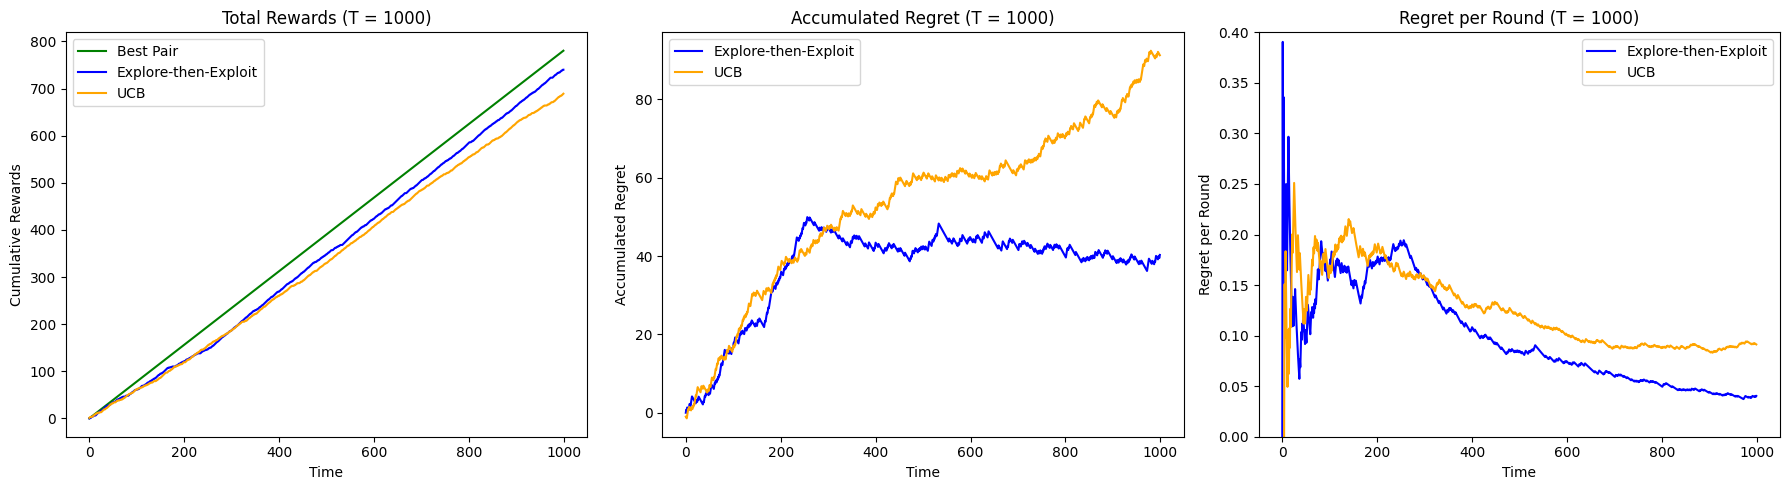

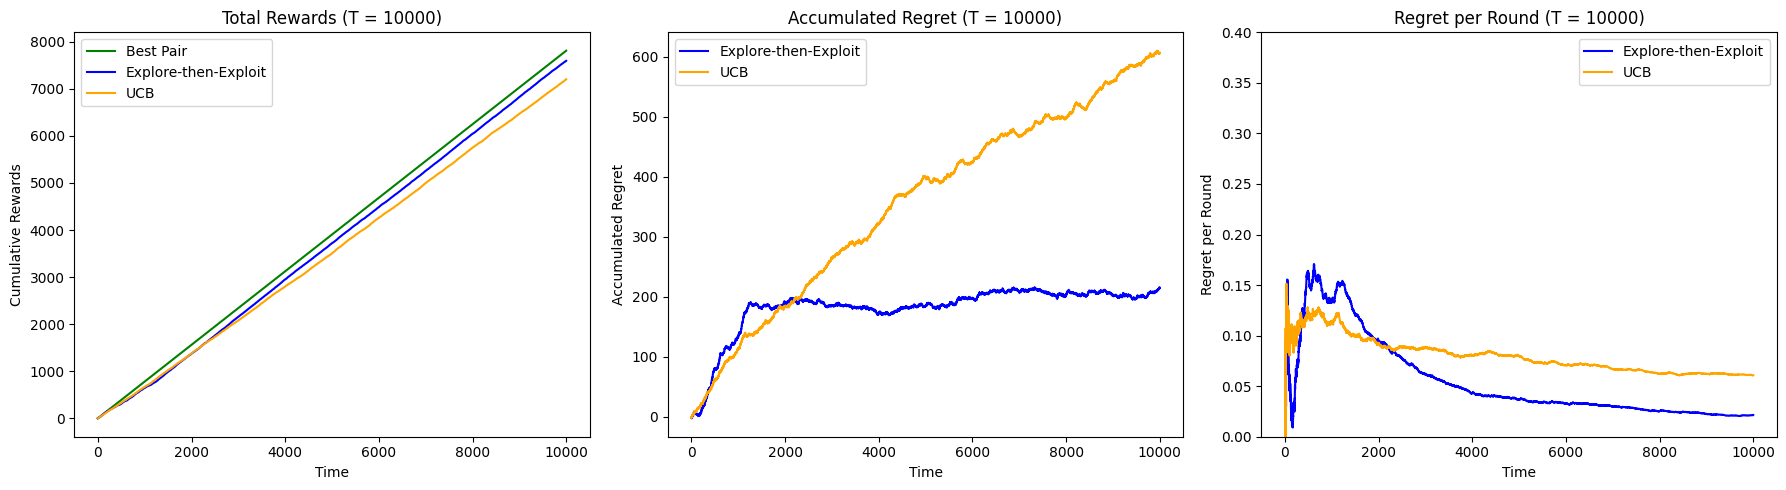

In [ ]:
for T in T_values:
    # Get cumulative reward series for each algorithm
    r_explore = explore_then_exploit(T)
    r_ucb = ucb(T)
    x = np.arange(T)

    # Cumulative rewards for best pair (if played every round)
    best_series = x * best_p_click

    # Calculate accumulated regret: difference between best series and algorithm
    regret_explore = best_series - r_explore
    regret_ucb = best_series - r_ucb

    # Regret per round
    regret_per_round_explore = regret_explore / (x + 1)
    regret_per_round_ucb = regret_ucb / (x + 1)

    # Create figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # (Left) Total rewards
    ax[0].plot(x, best_series, color='green', label='Best Pair')
    ax[0].plot(x, r_explore, color='blue', label='Explore-then-Exploit')
    ax[0].plot(x, r_ucb, color='orange', label='UCB')
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Cumulative Rewards")
    ax[0].set_title("Total Rewards (T = {})".format(T))
    ax[0].legend()

    # (Middle) Accumulated Regret
    ax[1].plot(x, regret_explore, color='blue', label='Explore-then-Exploit')
    ax[1].plot(x, regret_ucb, color='orange', label='UCB')
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Accumulated Regret")
    ax[1].set_title("Accumulated Regret (T = {})".format(T))
    ax[1].legend()

    # (Right) Regret per Round
    ax[2].plot(x, regret_per_round_explore, color='blue', label='Explore-then-Exploit')
    ax[2].plot(x, regret_per_round_ucb, color='orange', label='UCB')
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Regret per Round")
    ax[2].set_title("Regret per Round (T = {})".format(T))
    ax[2].set_ylim(0, 0.4)
    ax[2].legend()

    plt.tight_layout()
    plt.show()

## Instance-dependence Regret Analysis

Each suboptimal pair (arm) has a gap defined as:

$$
\Delta_{(i,j)} = \texttt{best_p_click} - p\_clicks[(i,j)]
$$

For each suboptimal arm, the finite-time regret bound is given by:

$$
\text{Regret}_t = \frac{8 \log t}{\Delta_{(i,j)}} + \Delta_{(i,j)}
$$

Summing over all suboptimal pairs, the overall theoretical regret bound at time \(t\) becomes:

$$
\mathbb{E}[R(t)] \leq \sum_{(i,j) \text{ suboptimal}} \left( \frac{8 \log t}{\Delta_{(i,j)}} + \Delta_{(i,j)} \right)
$$

This bound shows that the regret grows logarithmically with \(t\) and depends on the gap for each suboptimal pair.

In the following section, the achieved cumulative regret from the UCB algorithm with the time-dependent theoretical regret curve.


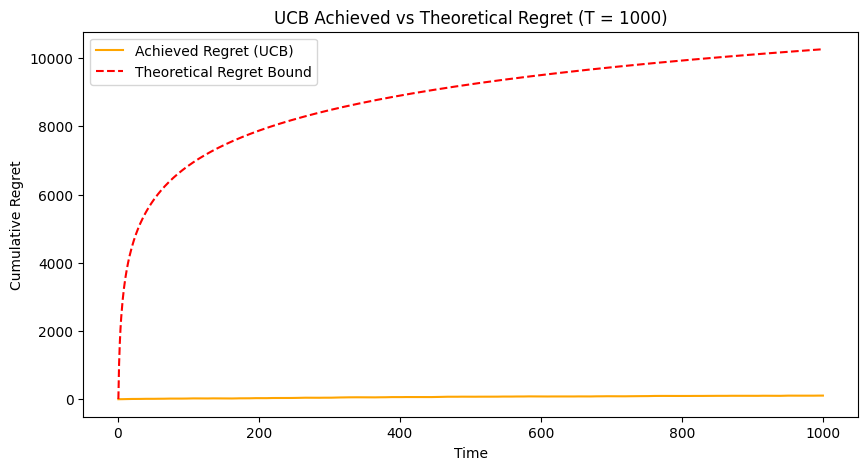

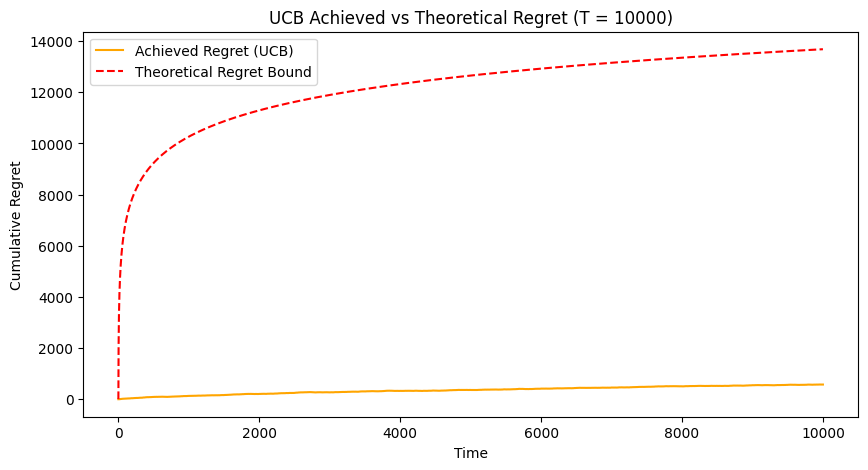

In [ ]:
# Theoretical Regret Calculation (Time-Dependent Version)
def theoretical_regret_ucb_time(t):
    instance_regret = {pair: best_p_click - p_clicks[pair]
                       for pair in pairs if p_clicks[pair] < best_p_click}
    regret_bound = sum((8 * np.log(t)) / delta + delta for delta in instance_regret.values() if delta > 0)
    return regret_bound

def theoretical_regret_curve(T):
    return np.array([theoretical_regret_ucb_time(t) for t in range(1, T+1)])

# Plot UCB Achieved vs Theoretical Regret (Time-Dependent Bound)!!!
for T in T_values:
    r_ucb = ucb(T) #achieved cumulative rewards from UCB
    best_series = np.arange(T) * best_p_click # ideal cumulative rewards if optimal pair was played always
    achieved_regret = best_series - r_ucb   # achieved cumulative regret
    theoretical_regret = theoretical_regret_curve(T) # Time-dependent theoretical regret

    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, T+1), achieved_regret, label='Achieved Regret (UCB)', color='orange')
    plt.plot(np.arange(1, T+1), theoretical_regret, label='Theoretical Regret Bound', linestyle='dashed', color='red')
    plt.xlabel("Time")
    plt.ylabel("Cumulative Regret")
    plt.title(f"UCB Achieved vs Theoretical Regret (T = {T})")
    plt.legend()
    plt.show()
